In [11]:
import os, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms

from dataset import MilkSignalDataset

from transforms import (AddGaussianNoiseInPersents, 
                        CenterSignal, 
                        ScaleSignal, 
                        SmoothSignal, 
                        IntensityFilter)

from ConvRegressor import *
from LinearRegressor import *
from pytorch_trainer import Trainer
from TrainUtils import evaluate_model, accuracy_metric, get_loaders, MSE, MAE, RMSE
from PlotUtils import plot_predicted_signals, get_plotted_signals

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# transform = transforms.Compose([ScaleSignal()])
dataset = MilkSignalDataset(file_path="data\\train_data_1000_scaled_25", transforms=None)

In [17]:
len(dataset)

138700

<Figure size 1152x720 with 0 Axes>

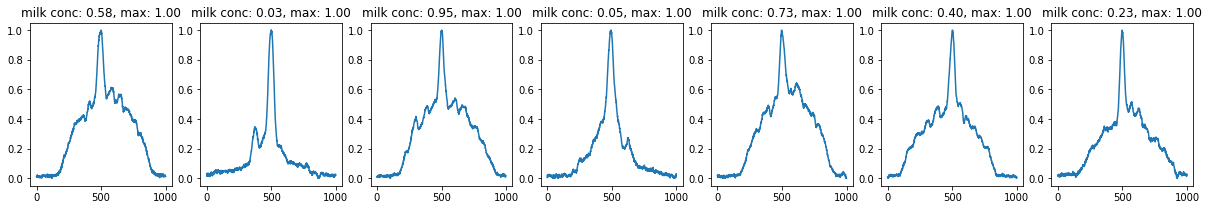

In [13]:
indices = np.random.choice(np.arange(len(dataset)), 7, replace=False)
plt.figure(figsize=(16, 10))
dataset.visualize_samples(indices=indices)

In [14]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss().type(torch.cuda.FloatTensor)
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat, y))

def get_model(train_loader, val_loader):
    device = torch.device("cuda:0")
    
    pred_cnt: int = 1
    nn_model = ConvRegressor(in_channels=1, predictions_count=pred_cnt)
    nn_model = nn_model.type(torch.cuda.FloatTensor)
    nn_model = nn_model.to(device)
    
    trainer = Trainer(nn_model, train_loader, val_loader, same_shape_tagret=True)
    loss_fn = RMSELoss().type(torch.cuda.FloatTensor)
    opt = optim.AdamW(nn_model.parameters(), weight_decay=5e-2, lr=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

    trainer.train(opt=opt, 
                  loss_fn=loss_fn, 
                  metric_fn=MAE, 
                  device=device, 
                  epochs=75, 
                  scheduler=scheduler)
    return nn_model

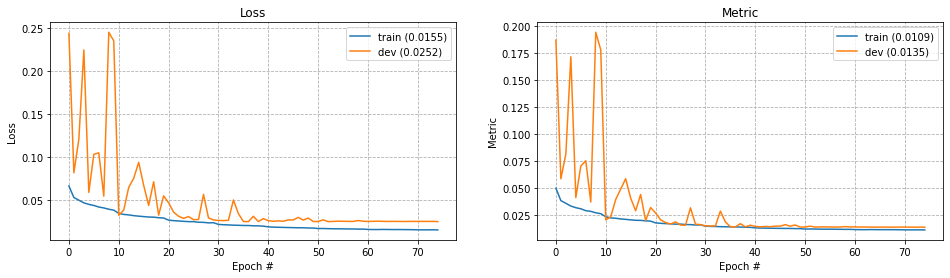

In [15]:
dataloaders, datasets = get_loaders(model_dataset=dataset, batch_size=100)
model = get_model(train_loader=dataloaders["train"], val_loader=dataloaders["val"])

# best was 0.0254, 0.0134

In [16]:
torch.save(model.state_dict(), "1000_3.pth")